# 0. Import libraries

In [1]:
import cv2                                        # Image processing with OpenCV
import lightgbm as lgb                            # Gradient boosting framework that uses tree-based learning algorithms
import matplotlib.patches as patches              # Plotting geometric shapes such as rectangles
import matplotlib.pyplot as plt                   # Plotting library
import numpy as np                                # Numerical operations on arrays
import os                                         # Operating system interfaces, like file and directory operations
import pickle                                     # Serializing and deserializing Python object structures
import random                                     # Generating pseudo-random numbers for various distributions
from joblib import Parallel, delayed              # Parallel processing utilities
from joblib import dump, load                     # Serialization and deserialization of models for efficient saving and loading
from skimage.feature import hog                   # Histogram of Oriented Gradients feature extraction
from sklearn.ensemble import (                    # Ensemble classifiers for combining predictions of several base estimators
    GradientBoostingClassifier, 
    RandomForestClassifier
)
from sklearn.linear_model import LogisticRegression # Logistic regression classifier
from sklearn.metrics import (                      # Metrics for evaluating classification performance
    accuracy_score, 
    classification_report, 
    precision_score, 
    recall_score, 
    f1_score
)
from sklearn.model_selection import train_test_split # Utility for splitting data into train and test sets
from sklearn.neighbors import KNeighborsClassifier   # Classifier implementing the k-nearest neighbors vote
from sklearn.preprocessing import StandardScaler     # Standardize features by removing the mean and scaling to unit variance
from sklearn.svm import SVC                          # Support Vector Classifier for supervised learning
import xgboost as xgb                                # Optimized gradient boosting library

# 1. Helper functions preprocessing

In [2]:
DATA_PATH = "../datasets/"
DATA_PROCESSED_PATH = "../datasets/datasets_processed/"

def convert_label_patch(label_patch, image_width, image_height):
    """
    Convert label patch format from center point to top-left and bottom-right coordinates.

    Parameters:
    label_patch (list): A list containing x_center, y_center, width, and height of the labeled patch, 
                        all scaled between 0 and 1.
    image_width (int): The width of the image.
    image_height (int): The height of the image.

    Returns:
    tuple: A tuple containing the top-left (x1, y1) and bottom-right (x2, y2) coordinates of the label patch.
    """
    x_center, y_center, width, height = label_patch[1], label_patch[2], label_patch[3], label_patch[4]
    x1 = (x_center - width / 2) * image_width
    y1 = (y_center - height / 2) * image_height
    x2 = (x_center + width / 2) * image_width
    y2 = (y_center + height / 2) * image_height

    return (x1, y1, x2, y2)

def compute_iou(box1, box2):
    """
    Compute the Intersection over Union (IoU) of two boxes.

    Parameters:
    box1 (tuple): A tuple containing the top-left (x1, y1) and bottom-right (x2, y2) coordinates of the first box.
    box2 (tuple): A tuple containing the top-left (x1, y1) and bottom-right (x2, y2) coordinates of the second box.

    Returns:
    float: The IoU of the two boxes.
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    intersection_area = max(0, x2_inter - x1_inter) * max(0, y2_inter - y1_inter)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])

    union_area = box1_area + box2_area - intersection_area

    if union_area == 0:
        return 0

    return intersection_area / union_area

def check_patch_overlap(label_patch, random_patch, image_width, image_height):
    """
    Check if a random patch overlaps with a label patch in an image.

    Parameters:
    label_patch (list): A list containing the class of the box, 
                        x_center, y_center, width, and height of the labeled patch, 
                        all scaled between 0 and 1.
    random_patch (list): A list containing the top-left (x_start, y_start) and 
                         bottom-right (x_end, y_end) coordinates of the random patch.
    image_width (int): The width of the image.
    image_height (int): The height of the image.

    Returns:
    bool: True if the patches overlap, False otherwise.
    """
    patch = convert_label_patch(label_patch, image_width, image_height)
    return compute_iou(patch, random_patch) > 0

def extract_bee_patches(image, boxes, patch_size):
    """
    Extract bee patches from an image.

    This function processes a given image to extract patches centered at the locations specified by bounding boxes. Each patch is then used to compute its Histogram of Oriented Gradients (HOG) features. These patches are assumed to contain bees, and the function is typically used for training a classifier to detect bees.

    Parameters:
    - image (numpy.ndarray): The input image from which bee patches are to be extracted.
    - boxes (list of lists/tuples): A list of bounding boxes in YOLOv7 format with the format [class, x_center, y_center, width, height], where x_center and y_center are center coordinates of the box, scaled between 0 and 1 relative to image width and height.
    - patch_size (tuple): The size of the patches to be extracted, represented as (width, height).

    Returns:
    - bee_patches (list of tuples): A list where each element is a tuple containing the HOG features of a patch and a label (1 indicating bee).

    Note:
    - The function adjusts the starting point of each patch to ensure it is within the image boundaries. If the patch size exceeds the image boundary, padding is added to compensate.
    - HOG features are computed for each patch to provide a feature descriptor suitable for image classification tasks.
    """
    bee_patches = []
    img_height, img_width = image.shape[:2]

    for box in boxes:
        _, center_x, center_y, _, _ = box
        x_center, y_center = int(center_x * img_width), int(center_y * img_height)
        x_start, y_start = x_center - patch_size[0] // 2, y_center - patch_size[1] // 2
        x_start, y_start = max(0, min(x_start, img_width - patch_size[0])), max(0, min(y_start, img_height - patch_size[1]))
        patch = image[y_start:y_start + patch_size[1], x_start:x_start + patch_size[0]]
        if patch.shape[0] < patch_size[1] or patch.shape[1] < patch_size[0]:
            patch = cv2.copyMakeBorder(patch, top=0, bottom=patch_size[1] - patch.shape[0], left=0, right=patch_size[0] - patch.shape[1], borderType=cv2.BORDER_CONSTANT, value=[0, 0, 0])
        hog_features = hog(patch, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False, channel_axis=-1)
        bee_patches.append((hog_features, 1))
    return bee_patches

def extract_background_patches(image, boxes, patch_size, num_patches):
    """
    Extract non-overlapping background patches from an image.

    This function selects random patches from the background of an image (i.e., areas not covered by the provided bounding boxes) and computes their Histogram of Oriented Gradients (HOG) features. The process is repeated until the desired number of patches is extracted or a maximum number of attempts is reached.

    Parameters:
    - image (numpy.ndarray): The input image from which patches are to be extracted.
    - boxes (list of lists/tuples): A list of bounding boxes in YOLOv7 format with the format [class, x_center, y_center, width, height], where x_center, y_center, width, and height are all scaled between 0 and 1.
    - patch_size (tuple): The size of the patches to be extracted, represented as (width, height).
    - num_patches (int): The number of background patches to extract.

    Returns:
    - background_patches (list of tuples): A list where each element is a tuple containing the HOG features of a patch and a label (0 indicating background).

    Note:
    - The function attempts to extract a specified number of patches. However, if it's not possible within 'num_patches * 20' attempts (to avoid infinite loops), it returns the patches extracted up to that point.
    """
    background_patches = []
    img_height, img_width = image.shape[:2]
    attempts = 0
    max_attempts = num_patches * 20  # To avoid infinite loops

    while len(background_patches) < num_patches and attempts < max_attempts:
        # Randomly select a starting position for the patch
        x_start = random.randint(0, img_width - patch_size[0])
        y_start = random.randint(0, img_height - patch_size[1])
        window = [x_start, y_start, x_start + patch_size[0], y_start + patch_size[1]]

        # Check if this window overlaps with any bee box
        if not any(check_patch_overlap(box, window, img_width, img_height) for box in boxes):
            patch = image[y_start:y_start + patch_size[1], x_start:x_start + patch_size[0]]
            hog_features = hog(patch, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False, channel_axis=-1)
            background_patches.append((hog_features, 0))
        
        attempts += 1

    return background_patches

def preprocess_and_save_data(data_type, w_size):
    """
    Preprocesses bee image data and saves it for later use.

    This function processes images of bees and their corresponding labels by extracting bee patches and random background patches. It then saves these processed data points along with their labels to a pickle file for later use in machine learning tasks.

    Parameters:
    - data_type (str): A string representing the type of data being processed, e.g., 'train', 'test', or 'val'. This is used to specify the folder path where the images and labels are located.
    - w_size (tuple): The size of the patches to be extracted, represented as (width, height).

    Steps:
    1. It reads images and their corresponding label files from specified directories, ignoring .DS_Store and duplicate files.
    2. For each image, it extracts bee patches based on the bounding boxes provided in the label files.
    3. It also extracts background patches from each image, with the number being four times the number of bee patches.
    4. The data is shuffled to ensure randomness.
    5. Features and labels are separated and saved to a pickle file named after the data type.

    Note:
    - The function assumes a specific directory structure and file naming convention based on 'data_type'.
    - It ensures that each image contributes a balanced proportion of bee and background patches as might be encountered in the wild (much more background than bee patches).
    - The random seed is set to 42 for reproducibility.
    """
    data_path = DATA_PATH + data_type

    # List comprehension that ignores .DS_Store files and files ending with (1).jpg for images as those are duplicates (there are only three duplicates in the whole dataset)
    files_img = [data_path + "/images/" + file for file in os.listdir(data_path + "/images/") if not file.endswith('.DS_Store') and not file.endswith('(1).jpg')]
    # Same but replaces .jpg with .txt to get the label files
    files_lab = [data_path + "/labels/" + file.replace('.jpg', '.txt') for file in os.listdir(data_path + "/images/") if not file.endswith('.DS_Store') and not file.endswith('(1).jpg')]

    processed_data = []

    for f, l in zip(files_img, files_lab):
        image = cv2.imread(f)

        with open(l, 'r') as file:
            bounding_boxes = [list(map(float, line.split())) for line in file]

        # Extract bee patches
        bee_patches = extract_bee_patches(image, bounding_boxes, w_size)
        processed_data.extend(bee_patches)

        # Extract random background patches
        num_background_patches = len(bee_patches) * 4 # we extract 4 times as many background patches as bee patches for each image
        background_patches = extract_background_patches(image, bounding_boxes, w_size, num_background_patches)
        processed_data.extend(background_patches)

    random.seed(42)  # Set the seed
    random.shuffle(processed_data)

    features, labels = zip(*processed_data) 

    # Save processed data to disk
    file_path = DATA_PROCESSED_PATH + f'{data_type}.pkl'
    with open(file_path, 'wb') as file:
        pickle.dump((list(features), list(labels)), file)

# 2. Preprocess and save the data, load train, valid, test data into dictionary

In [3]:
# Example usage
win_size = (150, 150)
preprocess_and_save_data("train", win_size)
preprocess_and_save_data("valid", win_size)
preprocess_and_save_data("test", win_size)

In [4]:
data_types = ['train', 'valid', 'test']

features = {}
labels = {}

for data_type in data_types:
    with open(DATA_PROCESSED_PATH + f'{data_type}.pkl', 'rb') as file:
        hog_features, img_labels = pickle.load(file)
        features[data_type] = hog_features
        labels[data_type] = img_labels

# 3. Scale features

In [5]:
# Assuming features_dict and labels_dict are already populated as shown earlier
scaler = StandardScaler()
# Standardizing the training features
features['train_scaled'] = scaler.fit_transform(features['train'])
# Standardizing the validation features
features['valid_scaled'] = scaler.transform(features['valid'])
# Standardizing the test features
features['test_scaled'] = scaler.transform(features['test'])

# 4. Training models

## 4.0 Prepare function for training, evaluation and saving of machine learning models

In [6]:
def train_evaluate_save_model(clf, model_name, feature_set, label_set, target_names):
    # Train the model
    clf.fit(feature_set['train_scaled'], label_set['train'])

    # Predictions and evaluation
    y_pred = clf.predict(feature_set['valid_scaled'])
    print(f"{model_name} Classifier Report:")
    print(classification_report(label_set['valid'], y_pred, target_names=target_names))

    accuracy = accuracy_score(label_set['valid'], y_pred)
    print("Accuracy: {:.2f}%".format(accuracy * 100))

    # Save the trained model
    dump(clf, f'models/{model_name}_bee_classifier.joblib')

## 4.1 KNN

In [7]:
clf_knn = KNeighborsClassifier(n_neighbors=5, algorithm='auto')
train_evaluate_save_model(clf_knn, "knn", features, labels, ["background", "bee"])

knn Classifier Report:
              precision    recall  f1-score   support

  background       0.84      1.00      0.91      7872
         bee       1.00      0.21      0.35      1968

    accuracy                           0.84      9840
   macro avg       0.92      0.61      0.63      9840
weighted avg       0.87      0.84      0.80      9840

Accuracy: 84.24%


## 4.2 Logistic Regression

In [8]:
clf_lr = LogisticRegression(max_iter=3000, class_weight='balanced') # setting the class_weight parameter to 'balanced' will automatically adjust weights inversely proportional to class frequencies in the input data.
train_evaluate_save_model(clf_lr, "logistic_regression", features, labels, ["background", "bee"])

logistic_regression Classifier Report:
              precision    recall  f1-score   support

  background       0.98      0.98      0.98      7872
         bee       0.90      0.93      0.92      1968

    accuracy                           0.97      9840
   macro avg       0.94      0.95      0.95      9840
weighted avg       0.97      0.97      0.97      9840

Accuracy: 96.70%


### the performance of logistic regression seems satsifactory for our purposes and is computionally efficient, but we could also train more models like the following to optimise performance

## 4.3 Ligth GBM

In [9]:
clf_lgb = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, max_depth=-1, random_state=0)
train_evaluate_save_model(clf_lgb, "lightgbm", features, labels, ["background", "bee"])

[LightGBM] [Info] Number of positive: 13181, number of negative: 52724
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 2.744560 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2653020
[LightGBM] [Info] Number of data points in the train set: 65905, number of used features: 10404
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.200000 -> initscore=-1.386294
[LightGBM] [Info] Start training from score -1.386294
lightgbm Classifier Report:
              precision    recall  f1-score   support

  background       0.98      0.99      0.98      7872
         bee       0.97      0.90      0.93      1968

    accuracy                           0.97      9840
   macro avg       0.97      0.95      0.96      9840
weighted avg       0.97      0.97      0.97      9840

Accuracy: 97.49%


## 4.4 SVM - Linear Kernel

In [8]:
clf_svm_linear = SVC(kernel='linear', C=1.0)
train_evaluate_save_model(clf_svm_linear, "svm_linear", features, labels, ["background", "bee"])

## 4.5 SVM - RBF Kernel

In [ ]:
clf_svm_rbf = SVC(kernel='rbf', gamma='scale')
train_evaluate_save_model(clf_svm_rbf, "svm_rbf", features, labels, ["background", "bee"])

# 5. Evaluating model on test set using sliding window mechanism and NMS

## 5.0 Helper functions for evaluation

In [9]:
# Function to generate sliding windows
def sliding_window(image, stepSize, windowSize):
    """
    Generate a sliding window that moves across the image with a certain step size and window size.
    At each step, it yields the portion of the image within the window.

    Parameters:
    - image (numpy.ndarray): The image over which to slide the window.
    - stepSize (int): The number of pixels to skip in both x and y directions 
      between successive windows.
    - windowSize (tuple): The size of the window to slide over the image, given as (width, height).

    Yields:
    - tuple: A tuple containing the top-left x and y coordinates of the window,
             as well as the window's content as a slice of the image array.
    
    This generator function is used for object detection tasks where you need to evaluate
    different sections of an image in a grid-like fashion, starting from the top-left corner
    and moving across and down the image in increments defined by the step size.
    """
    for y in range(0, image.shape[0] - windowSize[1], stepSize):
        for x in range(0, image.shape[1] - windowSize[0], stepSize):
            yield (x, y, image[y:y + windowSize[1], x:x + windowSize[0]])

def non_max_suppression_fast(boxes, scores, overlapThresh):
    """
    Perform non-maximum suppression to eliminate redundant overlapping bounding boxes 
    with lower scores. Bounding boxes should be in the form of "start x, start y, end x, end y".

    Parameters:
    - boxes (numpy.ndarray): Array of bounding boxes of shape (N, 4) where N is 
      the number of boxes, and the columns represent the coordinates of each box.
    - scores (numpy.ndarray): Array of scores for each bounding box of shape (N,).
    - overlapThresh (float): Threshold for overlap in terms of IoU (Intersection over Union) 
      for which bounding boxes will be suppressed.

    Returns:
    - numpy.ndarray: Array of bounding boxes after non-max suppression.
    - list: List of indices of the bounding boxes that were kept after non-max suppression.
    """
    # If there are no boxes, return an empty list
    if len(boxes) == 0:
        return [], []

    # Initialize the list of picked indexes    
    pick = []

    # Grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    x2 = boxes[:,2]
    y2 = boxes[:,3]

    # Compute the area of the bounding boxes and sort the bounding
    # boxes by the score/probability of the detection
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    idxs = np.argsort(scores)

    # Keep looping while some indexes still remain in the indexes list
    while len(idxs) > 0:
        # Grab the last index in the indexes list, i.e., the index with the largest score
        # and add the index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)

        # Find the intersection
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])

        # Compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1)
        h = np.maximum(0, yy2 - yy1)

        # Compute the ratio of overlap between the current box and all other boxes
        overlap = (w * h) / area[idxs[:last]]

        # If there is sufficient overlap, suppress the current box
        idxs = np.delete(idxs, np.concatenate(([last], np.where(overlap > overlapThresh)[0])))

    # Return only the bounding boxes that were picked using the integer data type
    return boxes[pick].astype("int"), pick

def process_image(image_path, label_boxes_path):
    """
    Processes an image to detect objects (bees in this case) using a sliding window approach,
    feature extraction, and a machine learning classifier with non-max suppression.

    Parameters:
    - image_path (str): The path to the image file.
    - label_boxes_path (str): The path to the file containing the ground truth bounding boxes for the objects.

    Returns:
    - windows_coordinates (list): List of tuples representing the top-left coordinates of all windows processed.
    - windows_labels (list): List of boolean values indicating the presence of an object within each window.
    - windows_predictions_adjusted (list): List of boolean values indicating the presence of an object within each window after non-max suppression.
    - windows_bee_probabilities (numpy.ndarray): Array of probabilities corresponding to the positive class for each window.
    - nms_boxes (numpy.ndarray): Array of bounding boxes after applying non-max suppression.
    - bounding_boxes (list): List of ground truth bounding boxes for the objects.
    
    The function reads an image and its associated bounding boxes, applies a sliding window to extract
    features using Histogram of Oriented Gradients (HOG), scales the features, makes predictions using a
    pre-trained classifier, applies non-max suppression to refine the predictions, and returns the results.
    """
    # Read the image
    image = cv2.imread(image_path)
    img_height, img_width = image.shape[:2]

    # Read the bounding boxes (labels)
    with open(label_boxes_path, 'r') as file:
        bounding_boxes = [convert_label_patch(list(map(float, line.split())), img_width, img_height) for line in file]

    # Sliding window parameters
    patch_size = (150, 150)
    stride = 50  # Adjust as needed

    # Lists to keep track of data
    windows_coordinates = []
    windows_features = []
    windows_predictions = []
    windows_bee_probabilities = []
    windows_labels = []
    
    # Scan the image with sliding window
    for (x, y, window) in sliding_window(image, stepSize=stride, windowSize=patch_size):
        if window.shape[0] != patch_size[1] or window.shape[1] != patch_size[0]:
            continue

        # Extract HOG features from the window
        hog_feature = hog(window, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), block_norm='L2-Hys', visualize=False, channel_axis=-1)
        windows_features.append(hog_feature)
        windows_coordinates.append((x, y))
        coordinates = (x, y, x + patch_size[0], y + patch_size[1])

        label = False
        for box in bounding_boxes:
            if compute_iou(coordinates, box) > 0.5:
                label = True

        windows_labels.append(label)

    # Scale features and make predictions
    features_scaled = scaler.transform(windows_features)
    probability_scores = clf_lr.predict_proba(features_scaled)  # positive class scores

    # Store predictions and probabilities
    windows_bee_probabilities = probability_scores[:, 1]
    windows_predictions = windows_bee_probabilities > 0.5

    # Convert window coordinates to (x1, y1, x2, y2) format
    windows_coordinates_converted = [(x, y, x + patch_size[0], y + patch_size[1]) for (x, y) in windows_coordinates]

    # Filter for windows where bees are predicted
    bee_windows = [(coord, prob) for coord, prob, pred in zip(windows_coordinates_converted, windows_bee_probabilities, windows_predictions) if pred]

    # Extract the coordinates and the scores from the bee_windows
    boxes = np.array([coord for coord, _ in bee_windows])
    scores = np.array([prob for _, prob in bee_windows])

    # Apply Non-Maximum Suppression (NMS)
    nms_boxes, nms_pick = non_max_suppression_fast(boxes, scores, 0.1)

    # Initialize windows_predictions_adjusted with all False
    windows_predictions_adjusted = [False] * len(windows_predictions)
    # Iterate through the nms_boxes
    for box in nms_boxes:
        # Convert box to tuple for comparison
        box_tuple = tuple(box)
        index = windows_coordinates_converted.index(box_tuple)
        # Set the corresponding prediction to True
        windows_predictions_adjusted[index] = True

    return windows_coordinates, windows_labels, windows_predictions_adjusted, windows_bee_probabilities, nms_boxes, bounding_boxes

## 5.1 Quantitative Evaluation

In [10]:
# Load the trained model and scaler
clf_lr = load('models/logistic_regression_bee_classifier.joblib')

# Load images and labels
data_path = DATA_PATH + 'test'  # Make sure this is the correct path

# List comprehension that ignores .DS_Store files and files ending with (1).jpg for images as those are duplicates (there are only three duplicates in the whole dataset)
files_img = [data_path + "/images/" + file for file in os.listdir(data_path + "/images/") if not file.endswith('.DS_Store') and not file.endswith('(1).jpg')]
# Same but replaces .jpg with .txt to get the label files
files_lab = [data_path + "/labels/" + file.replace('.jpg', '.txt') for file in os.listdir(data_path + "/images/") if not file.endswith('.DS_Store') and not file.endswith('(1).jpg')]
# Initialize lists for accuracy metrics
all_predictions = []
all_ground_truths = []

bees_predicted_per_image = []
bees_actual_per_image = []

# Parallel processing of images
results = Parallel(n_jobs=8)(delayed(process_image)(img_path, lab_path) for img_path, lab_path in zip(files_img, files_lab))

# Initialize lists for accuracy metrics
all_predictions = []
all_ground_truths = []
bees_predicted_per_image = []
bees_actual_per_image = []

# Extract results
for windows_coordinates, windows_labels, windows_predictions_adjusted, windows_bee_probabilities, nms_boxes, bounding_boxes in results:
    bees_predicted_per_image.append(sum(windows_predictions_adjusted))
    bees_actual_per_image.append(len(bounding_boxes))
    all_predictions.extend(windows_predictions_adjusted)
    all_ground_truths.extend(windows_labels)

# Calculate accuracy metrics
accuracy = accuracy_score(all_ground_truths, all_predictions)
precision = precision_score(all_ground_truths, all_predictions)
recall = recall_score(all_ground_truths, all_predictions)
f1 = f1_score(all_ground_truths, all_predictions)

In [11]:
# compute MAPE between number of bees predicted and actual number of bees
mape = np.mean(np.abs(np.array(bees_predicted_per_image) - np.array(bees_actual_per_image)) / np.array(bees_actual_per_image))
print(f"MAPE: {mape}")

# compute MAE between number of bees predicted and actual number of bees
mae = np.mean(np.abs(np.array(bees_predicted_per_image) - np.array(bees_actual_per_image)))
print(f"MAE: {mae}")

# compute MSE between number of bees predicted and actual number of bees
mse = np.mean(np.square(np.array(bees_predicted_per_image) - np.array(bees_actual_per_image)))

# compute RMSE between number of bees predicted and actual number of bees
rmse = np.sqrt(mse)
print(f"RMSE: {rmse}")

MAPE: 0.2076749272854263
MAE: 3.5588235294117645
RMSE: 4.652639984302398


# 5.2 Qualitative Evaluation on a single image from the test set

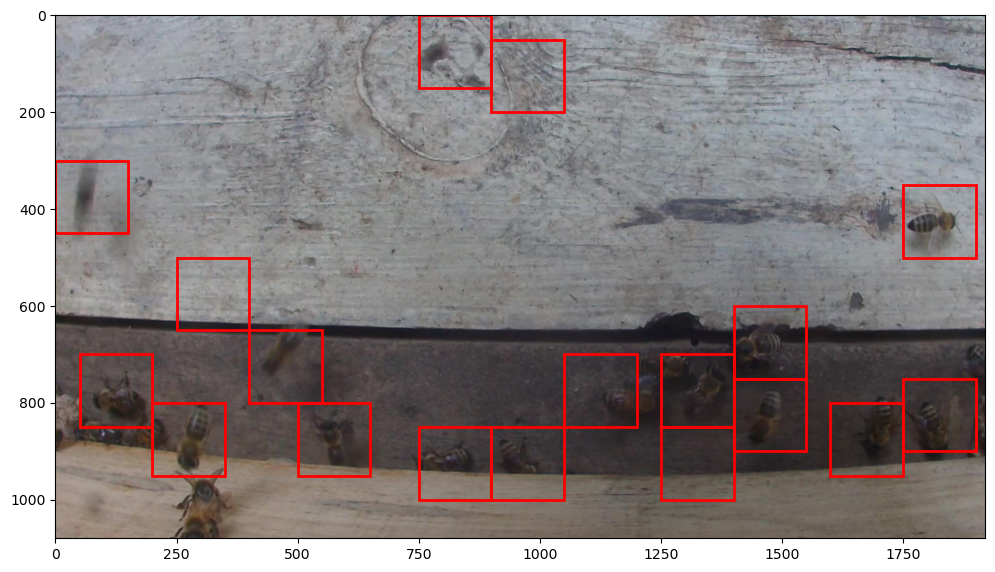

In [13]:
# Read the image
image_path = "../datasets/test/images/2022-03-26-10-00-061_jpg.rf.0f5417fc126dac336063bcf6ce75ca41.jpg"
label_boxes_path = "../datasets/test/labels/2022-03-26-10-00-061_jpg.rf.0f5417fc126dac336063bcf6ce75ca41.txt"

# Load the trained model and scaler
clf_lr = load('models/logistic_regression_bee_classifier.joblib')

windows_coordinates, windows_labels, windows_predictions_adjusted, windows_bee_probabilities, nms_boxes, bounding_boxes = process_image(image_path, label_boxes_path)
        
# Plotting function after NMS
def plot_predictions_with_nms(image_path, nms_boxes):
    image = cv2.imread(image_path)
    fig, ax = plt.subplots(1, figsize=(12, 12))
    ax.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))

    # Go through all NMS filtered boxes and plot them
    for box in nms_boxes:
        x, y, x2, y2 = box
        rect = patches.Rectangle((x, y), x2 - x, y2 - y, linewidth=2, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Call the function with the image and NMS boxes
plot_predictions_with_nms(image_path, nms_boxes)